In [ ]:
from keras.callbacks import ModelCheckpoint


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import os
import tensorflow as tf
import skimage.transform as skTrans
from sklearn.model_selection import train_test_split
import scipy
import torch
import io
from io import BytesIO
import seaborn as sns
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv3D, MaxPooling3D, InputLayer
from tensorflow.keras.layers import BatchNormalization
from keras import Input

In [ ]:
participant_metadata = pd.read_csv("drive/MyDrive/dementia/ADNI1_Complete_1Yr_1.5T_11_16_2022.csv")
participant_metadata.head()
participant_metadata = participant_metadata[['Image Data ID', 'Group','Age', 'Sex']]
participant_metadata.rename(columns={'Image Data ID':'MRI_ID', 'Group':'Diagnosis'}, inplace=True)

In [ ]:
#ftiaxnw dataframe me path tis mri kai antistoixis diagnosis

path = "drive/MyDrive/dementia"
list_dir = os.listdir(path)
final_df = pd.DataFrame(columns=["MRI_Path", "Diagnosis"])
for i in range(0,2294):
	for nifti in list_dir:
		if participant_metadata.MRI_ID[i] in nifti:
			print(str(participant_metadata.MRI_ID[i]) + " added")
			new_row = {"MRI_Path" : nifti, "Diagnosis" : participant_metadata.Diagnosis[i]}
			final_df = pd.concat([final_df,pd.DataFrame([new_row])], ignore_index=True)

In [ ]:
print(final_df.groupby(final_df.Diagnosis).count())


           MRI_Path
Diagnosis          
AD              320
CN              443
MCI             715


In [ ]:
list_of_paths = []
diagnosis = []

In [ ]:
list_of_paths = final_df['MRI_Path'].tolist()
diagnosis = final_df['Diagnosis'].tolist()

In [ ]:
def show_mri(img):
  mri = nib.load('drive/MyDrive/dementia/' + list_of_paths[img])
  data = mri.get_fdata()
  print(data.shape)
  data = remove_zero_rows_columns_slices(data)
  print(data.shape)

  # Plot every layer of the MRI in a grid
  num_layers = data.shape[-1]
  num_cols = 10  # number of columns in the grid
  num_rows = num_layers // num_cols + 1  # number of rows in the grid
  fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

  for i, ax in enumerate(axs.flatten()):
      if i < num_layers:
          ax.imshow(data[:, i, :], cmap='gray')
          y_bottom, y_top = ax.get_ylim()
          y_bottom += (y_top - y_bottom)
          ax.axhline(y=y_bottom, color='r', linestyle='--')
      ax.axis('off')
      
  plt.subplots_adjust(wspace=0, hspace=0)
  plt.show()

(192, 192, 160)
(124, 138, 118)


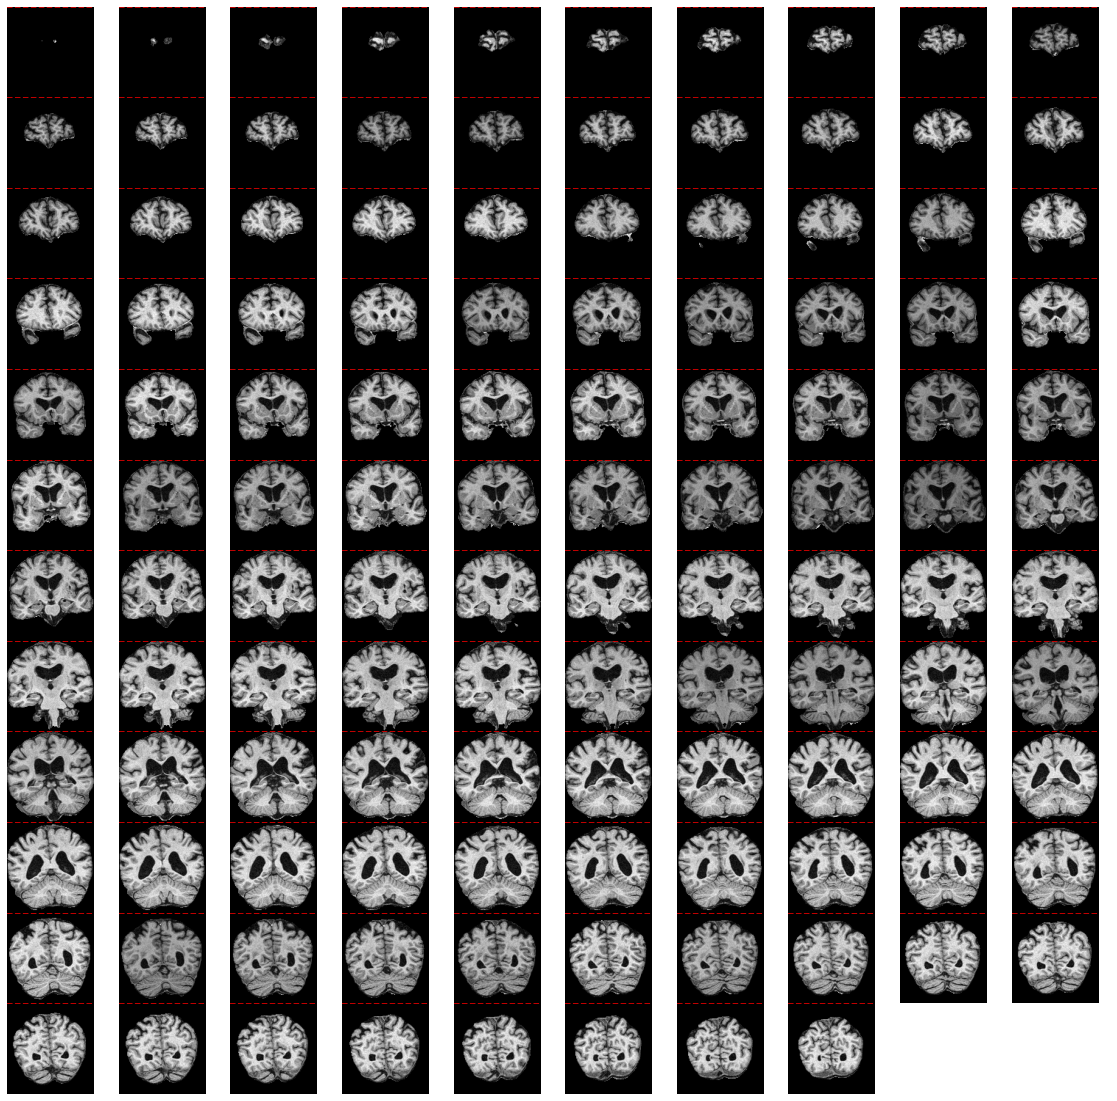

In [ ]:
show_mri(20)

In [ ]:
def remove_zero_rows_columns_slices(data):
    # Find the slices that have only zero values
    blank_slices = np.where(~np.all(data == 0, axis=(1, 2)))[0]
    
    # Remove the blank slices from the beginning and end of the data
    first_valid_slice = 0 if len(blank_slices) == 0 else blank_slices[0]
    last_valid_slice = data.shape[0] - 1 if len(blank_slices) == 0 else blank_slices[-1]
    data = data[first_valid_slice:last_valid_slice + 1, :, :]
    
    # Find the rows that have only zero values
    blank_rows = np.where(~np.all(data == 0, axis=(0, 2)))[0]
    
    # Remove the blank rows from the beginning and end of the data
    first_valid_row = 0 if len(blank_rows) == 0 else blank_rows[0]
    last_valid_row = data.shape[1] - 1 if len(blank_rows) == 0 else blank_rows[-1]
    data = data[:, first_valid_row:last_valid_row + 1, :]
    
    # Find the columns that have only zero values
    blank_columns = np.where(~np.all(data == 0, axis=(0, 1)))[0]
    
    # Remove the blank columns from the beginning and end of the data
    first_valid_column = 0 if len(blank_columns) == 0 else blank_columns[0]
    last_valid_column = data.shape[2] - 1 if len(blank_columns) == 0 else blank_columns[-1]
    data = data[:, :, first_valid_column:last_valid_column + 1]
    
    return data

In [ ]:
def show_slices(img):
	slice_x = img[50,:,:]
	slice_y = img[:,50,:]
	slice_z = img[:,:,50]
	slices = [slice_x, slice_y, slice_z]

	fig,axis = plt.subplots(1,len(slices))
	for i, slice in enumerate(slices):
	  axis[i].imshow(slice.T, cmap="gray", origin="lower")
	plt.show()

(256, 256, 166)
(256, 256, 166)


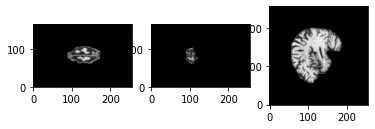

(161, 170, 117)


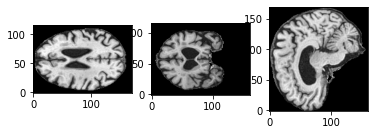

In [ ]:
mri = nib.load("drive/MyDrive/dementia/" + list_of_paths[200])
data = mri.get_fdata()
or_shape = data.shape
print(mri.shape)
print(or_shape)

show_slices(data)
or_voxel_size = find_voxel_size(mri) 
#print(or_voxel_size)

removed_shape = remove_zero_rows_columns_slices(data).shape
print(removed_shape)
show_slices(remove_zero_rows_columns_slices(data))
#new_voxel = or_voxel_size*(np.array(or_shape) / np.array(removed_shape))
#print(new_voxel)

In [ ]:
def find_voxel_size(mri):
  return mri.header["pixdim"][1:4]

In [ ]:
binary_list_of_paths = []
binary_diagnosis = []

def keep_binary(start_index, end_index):
    for i in range(start_index, end_index):
        if diagnosis[i] != "MCI":
            binary_list_of_paths.append(list_of_paths[i])
            binary_diagnosis.append(int(diagnosis[i] == "AD"))
            print("appended MRI number " + str(i))
    print(len(binary_list_of_paths), len(binary_diagnosis))

In [ ]:
keep_binary(0,len(list_of_paths))

In [ ]:
data = {'MRI_Path': binary_list_of_paths, 'Diagnosis': binary_diagnosis}
binary_df = pd.DataFrame(data)

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(binary_list_of_paths, binary_diagnosis, test_size=0.2, random_state=127)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=127)

# Print the number of samples in each set
print("Training samples:", len(X_train))
print("Validation samples:", len(X_val))
print("Testing samples:", len(X_test))

Training samples: 610
Validation samples: 76
Testing samples: 77


In [ ]:
print(Counter(y_train), Counter(y_val), Counter(y_test))

In [ ]:
y_train[:5]

[1, 0, 0, 0, 0]

I want each diagnosis to be in the form of a boolean array

In [ ]:
def get_train_nifti_diagnosis_tuple(niftipath_diag):
  for j in range (len(X_train)):
    niftipath_diag.append((X_train[j], y_train[j]))
  return niftipath_diag

def get_val_nifti_diagnosis_tuple(niftipath_diag):
  for j in range (len(X_val)):
    niftipath_diag.append((X_val[j], y_val[j]))
  return niftipath_diag

def get_test_nifti(niftipath):
  for j in range(len(X_test)):
    niftipath.append(X_test[j])
  return niftipath

In [ ]:
empty1 = []
tuples_of_train_filepaths_diagnosis = get_train_nifti_diagnosis_tuple(empty1)
print(len(tuples_of_train_filepaths_diagnosis))

empty2 = []
tuples_of_val_filepaths_diagnosis = get_val_nifti_diagnosis_tuple(empty2)
print(len(tuples_of_val_filepaths_diagnosis))

empty3 = []
test_filepaths = get_test_nifti(empty3)
print(len(test_filepaths))

610
76
77


In [ ]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

In [ ]:
def create_train_tfrecord(outfile, tuples):
  path = "/content/drive/MyDrive/dementia/"
  writer = tf.io.TFRecordWriter(outfile)
  for nifti_path, diagnosis in tuples:

   # diagnosis = diagnosis.astype(int).tolist()
   # diagnosis = [int(b) for b in diagnosis]


#ara 0 gia ad(3augm) 1 gia cn(2 augm) kai 2 gia mci(1 augm)

    print("Processing:")
    print("  nifti: ", nifti_path)
    print("  diagnosis:  ", diagnosis)	

    nii = nib.load(path + nifti_path)

    nii_data = nii_augmented.get_fdata().astype('float32')
    non_zero_nii = remove_zero_rows_columns_slices(nii_data)
    resized = skTrans.resize(non_zero_nii, (90,90,70), order=3, preserve_range=True)
    

    # Dimensions
    #rows, cols, slices = resized.shape

    print("Normalized MRI added to tfrecord .. ")


    data_point = tf.train.Example(features=tf.train.Features(feature={
      'nifti': _float_feature(resized.flatten()),
      'diagnosis': _int64_feature(diagnosis)})) #ta raw ta exw kanei toString ara bytes feature
            
    writer.write(data_point.SerializeToString())

  writer.close()

In [ ]:
def create_val_tfrecord(outfile, tuples):
  path = "/content/drive/MyDrive/dementia/"
  writer = tf.io.TFRecordWriter(outfile)
  for nifti_path, diagnosis in tuples:


    print("Processing:")
    print("  nifti: ", nifti_path)
    print("  diagnosis:  ", diagnosis)	

    nii = nib.load(path + nifti_path)
    nii_data = nii.get_fdata().astype('float32')
    non_zero_nii = remove_zero_rows_columns_slices(nii_data)
    resized = skTrans.resize(non_zero_nii, (90,90,70), order=3, preserve_range=True)


    # Dimensions
    rows, cols, slices = resized.shape

    print("DIMS: rows:" + str(rows) + " - cols:" + str(cols) + " - slices:"+ str(slices))


    data_point = tf.train.Example(features=tf.train.Features(feature={
      'nifti': _float_feature(resized.flatten()),
      'diagnosis': _int64_feature(diagnosis)})) #ta raw ta exw kanei toString ara bytes feature
      
        
    writer.write(data_point.SerializeToString())

  writer.close()

In [ ]:
def create_test_tfrecord(outfile, niftis): #no diagnosis
  path = "/content/drive/MyDrive/dementia/"
  writer = tf.io.TFRecordWriter(outfile)
  for nifti_path in niftis:

    print("Processing:")
    print("  nifti: ", nifti_path)

    nii = nib.load(path + nifti_path)
    nii_data = nii.get_fdata().astype('float32')
    non_zero_nii = remove_zero_rows_columns_slices(nii_data)
    resized = skTrans.resize(non_zero_nii, (90,90,70), order=3, preserve_range=True)



    # Dimensions
    rows, cols, slices = resized.shape

    print("DIMS: rows:" + str(cols) + " - cols:" + str(cols) + " - slices:"+ str(slices))


    data_point = tf.train.Example(features=tf.train.Features(feature={
      'nifti': _float_feature(resized.flatten())})) 
        
    writer.write(data_point.SerializeToString())

  writer.close()

In [ ]:
equalratio_binary_train = "/content/drive/MyDrive/dementia/equalratio_binary_train" #NUM_AUGM = 5
create_train_tfrecord(equalratio_binary_train, tuples_of_train_filepaths_diagnosis)
equalratio_binary_val = "/content/drive/MyDrive/dementia/equalratio_binary_val"
create_val_tfrecord(equalratio_nor_binary_val, tuples_of_val_filepaths_diagnosis)
equalratio_binary_test = "/content/drive/MyDrive/dementia/equalratio_binary_test"
create_test_tfrecord(equalratio_binary_test, X_test)

In [ ]:
equalratio_binary_train = "/content/drive/MyDrive/dementia/equalratio_binary_train"
equalratio_binary_val = "/content/drive/MyDrive/dementia/equalratio_binary_val"
equalratio_binary_test = "/content/drive/MyDrive/dementia/equalratio_binary_test"

In [ ]:
record_iterator = tf.compat.v1.io.tf_record_iterator(binary_train)

counter = 0
for string_record in record_iterator:
    counter += 1

print(counter)

In [ ]:
def decode(serialized_example):
  features = tf.io.parse_single_example(
    serialized_example,
    features={'nifti': tf.io.FixedLenFeature([90,90,70], tf.float32),
    'diagnosis': tf.io.FixedLenFeature([1], tf.int64)})
  return features['nifti'], features['diagnosis']

In [ ]:
def decode_test(serialized_example):
  features = tf.io.parse_single_example(
    serialized_example,
    features={'nifti': tf.io.FixedLenFeature([90,90,70], tf.float32)})

  return features['nifti']

In [ ]:
trn_dataset = tf.data.TFRecordDataset(equalratio_binary_train).shuffle(663).map(decode)
vl_dataset = tf.data.TFRecordDataset(equalratio_binary_val).map(decode)
tst_dataset = tf.data.TFRecordDataset(equalratio_binary_test).map(decode_test)

In [ ]:
BATCH_SIZE = 16

def create_data_batches(dataset, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
  if test_data:
    print("Creating test data batches .. ") #niftis only
    data_batches = dataset.batch(BATCH_SIZE)

    return data_batches
  
  elif valid_data:
    print("Creating valid data batches ..") #niftis and diagnosis
    data_batches = dataset.batch(BATCH_SIZE)
    return data_batches
  
  else:
    print("Creating train data batches ..")
    data_batches = dataset.shuffle(len(X_test)).batch(BATCH_SIZE)
    return data_batches

In [ ]:
test_data = create_data_batches(tst_dataset, test_data = True)
val_data = create_data_batches(vl_dataset, valid_data = True)
train_data = create_data_batches(trn_dataset)

Creating test data batches .. 
Creating valid data batches ..
Creating train data batches ..


In [ ]:
test_data, val_data, train_data #to None antistoixei sto batch size

(<BatchDataset element_spec=TensorSpec(shape=(None, 90, 90, 70), dtype=tf.float32, name=None)>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 90, 90, 70), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 90, 90, 70), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>)

In [ ]:
class_weights = {0: 1/443, 1: 1/320}

sum_weights = sum(class_weights.values())
for i in range(len(class_weights)):
    class_weights[i] /= sum_weights

In [ ]:
class_weights

{0: 0.419397116644823, 1: 0.580602883355177}

In [ ]:
#functional
from keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, Dropout,Concatenate 
from keras.models import Model
from keras import regularizers


In [ ]:

class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True
        )
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True
        )
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        return self.scale * (inputs - mean) / tf.sqrt(variance + 1e-5) + self.offset

In [ ]:
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, Activation, AveragePooling3D, Add, Multiply, GlobalAveragePooling3D, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


def residual_block(inputs, filters):
    x = Conv3D(filters, (3, 3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv3D(filters, (3, 3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    if inputs.shape[-1] != filters:
        shortcut = Conv3D(filters, (1, 1, 1), padding='same')(inputs)
    else:
        shortcut = inputs
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def attention_block(inputs, filters):
    g = Conv3D(filters, (1, 1, 1), padding='same')(inputs)
    g = Activation('relu')(g)
    g = Multiply()([g, inputs])
    return g

# Define input shape
input_shape = (90,90,70,1)
inputs = Input(shape=input_shape)

x = InstanceNormalization()(inputs) # instance normalization

x = Conv3D(16, (3, 3, 3), padding='same')(x)
x = Conv3D(32, (3, 3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = residual_block(x, 32)

x = AveragePooling3D((3, 3, 3))(x)
x = residual_block(x, 64)

x = AveragePooling3D((3, 3, 3))(x)
x = residual_block(x, 128)

x = AveragePooling3D((3, 3, 3))(x)
x = residual_block(x, 256)

y = attention_block(x,256)
x = Multiply()([x, y])
x = GlobalAveragePooling3D()(x)

x = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=inputs, outputs=x)


In [ ]:
# Define a callback to save the model weights after each epoch
checkpoint = ModelCheckpoint(filepath='drive/MyDrive/dementia/binaryweights6.{epoch:02d}-{val_accuracy:.2f}.h5',
                             monitor='val_accuracy',
                             save_best_only=True)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 90, 90, 70,  0           []                               
                                 1)]                                                              
                                                                                                  
 instance_normalization_1 (Inst  (None, 90, 90, 70,   2          ['input_2[0][0]']                
 anceNormalization)             1)                                                                
                                                                                                  
 conv3d_21 (Conv3D)             (None, 90, 90, 70,   896         ['instance_normalization_1[0][0]'
                                32)                              ]                          

In [ ]:
from keras.losses import binary_crossentropy
from sklearn.utils import compute_class_weight


In [ ]:
import inspect
from sklearn.utils.class_weight import compute_class_weight
print(inspect.signature(compute_class_weight))

(class_weight, *, classes, y)


In [ ]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:

# Compute class weights
train_labels = y_train
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

# Convert class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

# Train your model with class weights
history = model.fit(train_data,
                    epochs=90,
                    validation_data = val_data,
                    callbacks=[checkpoint],
                    class_weight=class_weight_dict)

In [ ]:
from tensorflow.keras.models import load_model


In [ ]:
tf.keras.utils.get_custom_objects()['InstanceNormalization'] = InstanceNormalization


In [ ]:
loaded_model = tf.keras.models.load_model('drive/MyDrive/dementia/binaryweights3.88-0.95.h5',custom_objects={'InstanceNormalization': InstanceNormalization})


In [ ]:
y_pred = model.predict(test_data)


5/5 [==============================] - 1s 192ms/step


In [ ]:
y_pred_rounded = np.round(y_pred)


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
accuracy = accuracy_score(y_test, y_pred_rounded)


In [ ]:
print(accuracy)

0.974025974025974


In [ ]:

confusion = confusion_matrix(y_test, y_pred_rounded)
confusion

array([[48,  1],
       [ 1, 27]])

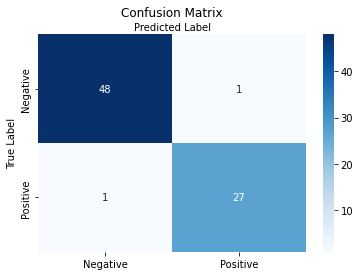

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Generate a sample confusion matrix

cm = confusion_matrix(y_test, y_pred_rounded)

# Define the class labels
# Define the class labels
class_names = ['Negative', 'Positive']

# Create the heatmap
ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Set the title and axis labels
ax.set_title('Confusion Matrix')
ax.xaxis.set_label_position('top')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Show the plot
plt.show()

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Set y-axis limits to zoom in on specific range of loss values

plt.ylim([0, 6])  # Set y-axis limits to zoom in on range of loss values

plt.show()